# Journal Recommendation System
    Project for CSCI 490/642 
    Created by:
    Kethan Sai Yaram
    Rory Miller
    Shaniel O. Rivas Verdejo 
    Eli Brottman
    Mohammed Taha Faridi

# Cleaning

In [1]:
import pandas as pd
import os
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
import numpy as np
pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_colwidth', -1)

In [2]:
df=pd.read_csv(r'.\dataextract.csv', index_col=0, dtype={'user_id': str})
df.dropna(inplace=True)

C:\Users\Rory Miller\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[df.Journal_Names != "0"] #remove rows with value zero
df = df[df.Title != "0"] #remove rows with value zero
df = df[df.Abstract != "0"]

In [4]:
df = df.apply(lambda x: x.astype(str).str.lower()) #convert to lower case

#filtering the Title column
df['Title'].replace(regex=True, inplace=True, to_replace=r'[\d+]', value=r'') #remove numbers.
#df['Title'].replace(regex=True, inplace=True, to_replace=r'[\W+]', value=r'') #remove special chars.
df['Title'] = df['Title'].str.replace('[^\w\s]','') #remove special characters
df['Title']= df['Title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #remove stop words

#filtering the Jourmal Names column
df['Journal_Names'].replace(regex=True, inplace=True, to_replace=r'[\d+]', value=r'') #remove numbers.
df['Journal_Names'] = df['Journal_Names'].str.replace('[^\w\s]','') #remove special characters
df['Journal_Names']= df['Journal_Names'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #remove stop words

df['Abstract'].replace(regex=True, inplace=True, to_replace=r'[\d+]', value=r'') #remove numbers.
df['Abstract'] = df['Abstract'].str.replace('[^\w\s]','') #remove special characters
df['Abstract']= df['Abstract'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #remove stop words


df = df.apply(lambda x: x.astype(str).str.lstrip()) #remove leading white spaces
df = df.apply(lambda x: x.astype(str).str.rstrip()) #remove ending white spaces

In [5]:
df['Firstseen'] = df['Firstseen'].apply(lambda x: x.split('t')[0])
df['Publish_date'] = df['Publish_date'].apply(lambda x: x.split('t')[0])

In [6]:
df['Journal_Names'].replace('', np.nan, inplace=True)
df['Title'].replace('', np.nan, inplace=True)
df['Abstract'].replace('', np.nan, inplace=True)

In [7]:
df.dropna(inplace=True) #drop rows with Nan(not a number)

In [8]:
df['titleAbs'] = df['Title'].map(str)+' '+df['Abstract'] #combine title and abstract into single cell

## Language Detection

In [9]:
from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [10]:
#select first 10000 as  data
df2 = df.head(10000)
df2['lang'] = df2.titleAbs.progress_map(detect)

C:\Users\Rory Miller\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#only keep english
df2 = df2.loc[df2.lang=='en']
#take data in english after 8000 as testing data
testingdf = df2.iloc[8000:]
#take first 8000 as training data
df2 = df2.head(8000)

In [12]:
from nltk.tokenize import sent_tokenize

In [13]:
#Tokenize into sentences
df2['sentences'] = df2.titleAbs.progress_map(sent_tokenize)

In [14]:
from nltk.tokenize import word_tokenize

In [15]:
#tokenize into words
df2['tokens'] = df2['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

In [16]:
from nltk import pos_tag

In [17]:
#parts of speech
df2['POS'] = df2['tokens'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])

In [18]:
# Inspired from https://stackoverflow.com/a/15590384
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
df2['tokens_sentences_lemmatized'] = df2['POS'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)



In [19]:
#Remove Stopwords

from nltk.corpus import stopwords

stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stopwords.words('English') + stopwords_verbs + stopwords_other

from itertools import chain # to flatten list of sentences of tokens into list of tokens

df2['Tokens'] = df2['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))

df2['Tokens'] = df2['Tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])


# LDA

In [20]:
from gensim.models import Phrases

absTokens = df2['Tokens'].tolist()
bigram_model = Phrases(absTokens)
trigram_model = Phrases(bigram_model[absTokens], min_count=1)
absTokens = list(trigram_model[bigram_model[absTokens]])

from gensim import corpora

dictionary_LDA = corpora.Dictionary(absTokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in absTokens]

from gensim import models
import numpy as np

np.random.seed(123456)
num_topics = 15
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary_LDA.keys()))

C:\Users\Rory Miller\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Rory Miller\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
C:\Users\Rory Miller\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 34 s


from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# print topics
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

In [21]:
#find topics for each article
topics = [lda_model[corpus[i]] for i in range(len(df2))]

In [22]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [23]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)
df2= df2.reset_index()

In [24]:
#add journal names to topic distribution per article
df3 = pd.concat([df2['Journal_Names'],document_topic],axis = 1, join='inner')

In [25]:
#map artical weights to journals by mean
df3 = df3.replace(0,np.NaN)
df4 = df3.groupby(['Journal_Names']).mean()
#reset index
df4.reset_index()

,Journal_Names,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,aa case reports,0.321498,NaN,0.434911,NaN,NaN,0.455429,NaN,0.034969,0.138991,NaN,NaN,NaN,0.264404,0.078987,NaN
1,aaps pharmsci,NaN,NaN,NaN,0.136722,NaN,NaN,NaN,0.055904,NaN,0.191652,NaN,NaN,NaN,0.520415,0.093840
2,aaps pharmscitech,0.037371,NaN,NaN,NaN,NaN,0.599549,NaN,NaN,0.086815,0.043633,NaN,0.231548,NaN,NaN,NaN
3,abdominal imaging,0.172817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529169,0.283290,NaN
4,abdominal radiology,NaN,NaN,NaN,NaN,NaN,0.106484,0.087961,NaN,0.079732,NaN,NaN,0.061188,0.397193,0.265403,NaN
5,academic emergency medicine,NaN,NaN,NaN,0.076682,NaN,0.104588,0.226118,0.119477,0.156806,0.103942,NaN,0.195833,0.285112,0.290821,0.044295
6,academic medicine,0.137197,0.043031,0.401455,0.023216,0.016463,0.082614,0.021536,0.043928,NaN,NaN,0.104350,0.116754,0.048712,0.162204,0.073964
7,academic pediatrics,0.050291,NaN,0.440411,NaN,NaN,NaN,NaN,NaN,0.158083,0.015741,0.021190,0.078058,NaN,0.083484,0.152441
8,academic radiology,0.075244,0.018771,0.361602,0.041837,NaN,0.215533,NaN,0.022984,NaN,NaN,NaN,0.087611,0.195034,0.226465,NaN
9,accident analysis prevention,0.066137,NaN,0.547203,NaN,0.040622,0.080310,NaN,NaN,NaN,NaN,NaN,0.034679,0.014904,0.358097,0.163328


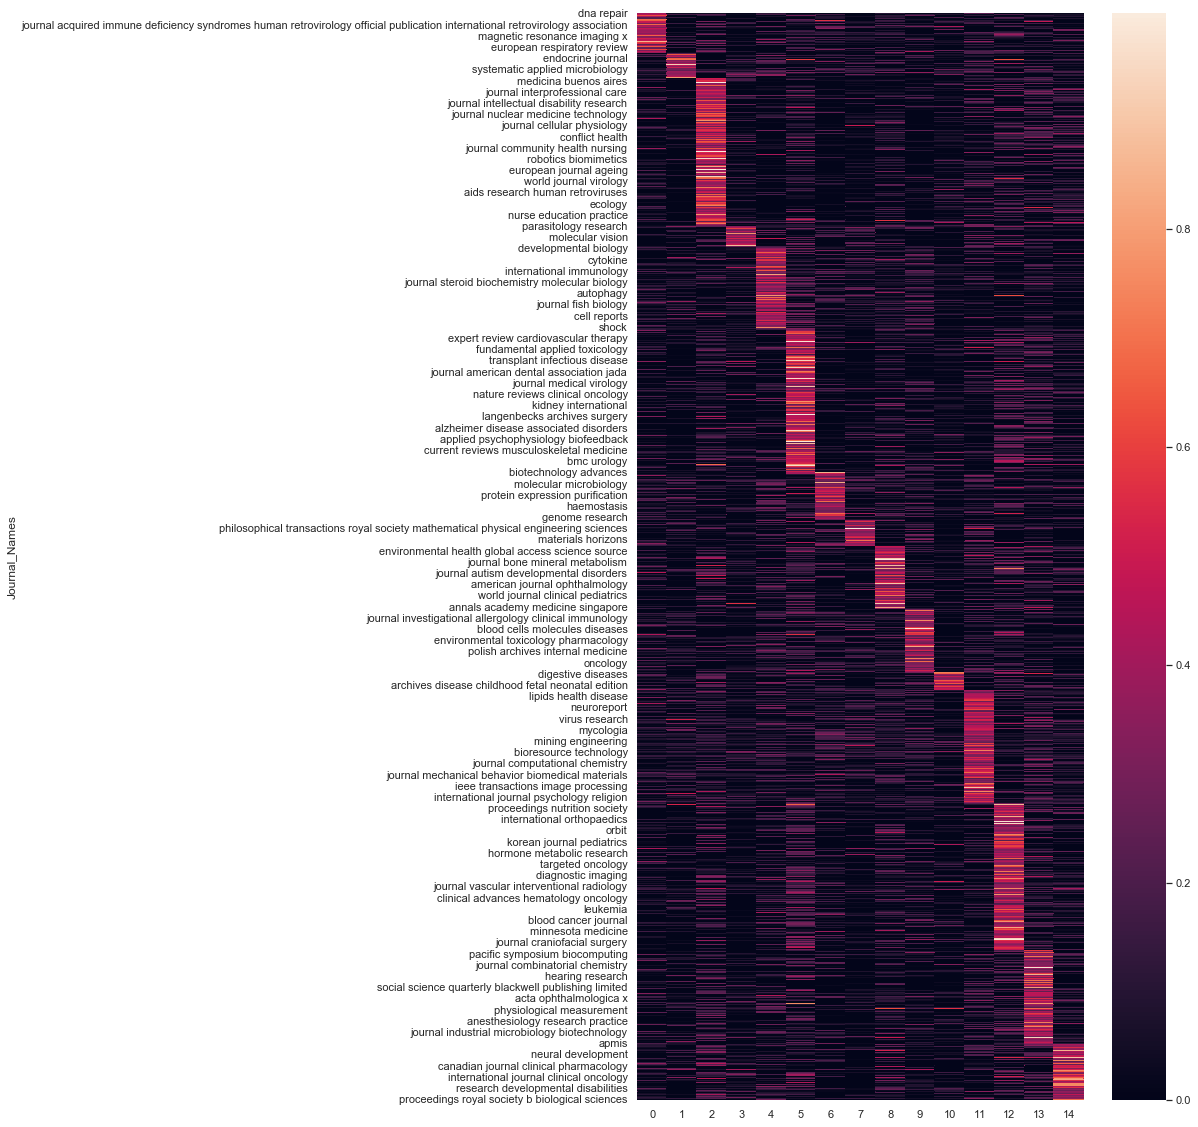

In [26]:
#show heatmap of topics in Journals
heatmapdf = df4.replace(np.NaN,-0)
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(heatmapdf.loc[heatmapdf.idxmax(axis=1).sort_values().index])

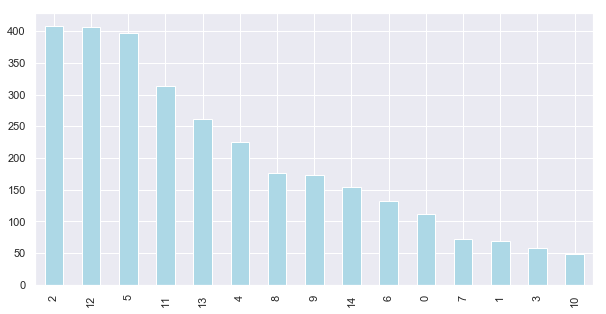

In [27]:
sns.set(rc={'figure.figsize':(10,5)})
heatmapdf.idxmax(axis=1).value_counts().plot.bar(color='lightblue')


%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)


# Testing a New Document

In [39]:
from scipy import stats

testingdf.reset_index()
docStartIndex = 3
numOfDocsToTest = 500 #len(testingdf)

In [40]:
df10 = pd.DataFrame()
for x in range(docStartIndex, docStartIndex + numOfDocsToTest ):    
    #testing one document
    documentNumberToTest = x
    documentTitle = testingdf['Title'].iloc[documentNumberToTest]
    document = testingdf['titleAbs'].iloc[documentNumberToTest]
    documentJournal = testingdf['Journal_Names'].iloc[documentNumberToTest] 
    tokens = word_tokenize(document)
    topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
    newDF = pd.DataFrame([(el[0], round(el[1],2)) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic', 'weight'])
    #print journal name and topics found in journal artical
    #print(documentJournal)
    #print(newDF)

    #store in new dataframe
    df6 = pd.DataFrame()
    df6['topic'] = newDF['topic']
    df6['tweight'] = newDF['weight']
    df6.topic = df6.topic.astype(int)
    df6.tweight = df6.tweight.astype(float)

    #put testing weights next to journal weights
    df7 = pd.DataFrame()
    for i in df6['topic']:
        #print(i)
        for j in df4[i]:
            df7[i] = df4[i]

    #run a weighted tau on all the journal weights and testing weights to determin a ranking
    df8 = pd.DataFrame()
    for journal, row in df7.iterrows():
        tau, _ = stats.weightedtau(df6['tweight'], row)
        df8[journal] = [tau]

    #sort the rankings
    df9=df8.T.sort_values(by=[0],ascending=False)
    df9=df9.reset_index()
    df9.rename(columns={'index': documentJournal}, inplace=True)
    df10 = pd.concat([df10, df9] , axis=1)
    #show the top 10 rankings and the actual journal it was published in
    #print('Article Title:\n ', documentTitle)
    #print('\nJournal Recomendation              Ranking\n' )
    #print(df9.head(10).to_string(index = False, header = False))
    #print('\n\nArticle was actually Published in:\n '  , documentJournal, '\n-----------------------------------------\n\n\n')

In [41]:
df10.to_csv('output.csv')

In [42]:
df10

,genes development,0,journal american chemical society,0,natural product reports,0,journal biological chemistry,0,journal american college surgeons,0,cell biochemistry function,0,annals surgical oncology,0,journal nuclear medicine,0,bmc palliative care,0,molecular ecology resources,0,neurology therapy,0,proceedings national academy sciences united states america,0,journal cell biology,0,chemsuschem,0,international journal clinical practice,0,advances experimental medicine biology,0,nordic journal psychiatry,0,journal european academy dermatology venereology,0,physical chemistry chemical physics pccp,0,trials,0,conversation,0,trials,0,veterinary immunology immunopathology,...,0,journal pharmacology experimental therapeutics,0,bmc neuroscience,0,trends pharmacological sciences,0,reproduction,0,american journal sports medicine,0,human reproduction update,0,malaysian journal pathology,0,aquaculture,0,journal homosexuality,0,developmental biology,0,cell death differentiation,0,journal biological chemistry,0,journal urology,0,plos computational biology,0,journal physical chemistry,0,surgical clinics north america,0,journal antimicrobial chemotherapy jac,0,journal sexual medicine,0,perspectives psychological science,0,pharmaceutical research,0,cochrane database systematic reviews,0,plant physiology,0
0,journal molecular biology,0.898061,chemosphere,0.946170,zootaxa,1.0,journal medicinal chemistry,0.774000,international journal cancer,1.000000,molecular cancer research,0.908456,springerplus,0.888638,circulation,1.000000,american journal public health,0.960208,american journal tropical medicine hygiene,0.878488,archives gerontology geriatrics,0.813699,cellular physiology biochemistry,0.941821,brain research,0.710172,current biology,0.828271,medical hypotheses,0.743180,canadian journal gastroenterology,0.904762,environmental pollution,1.000000,environmental technology,0.975900,advanced healthcare materials,0.848861,neuropsychologia,0.831371,zootaxa,1.0,frontiers cardiovascular medicine,1.000000,molecular carcinogenesis,...,0.901460,applied environmental microbiology,0.827617,journal nutrition,0.736374,international journal radiation oncology biology physics,0.907265,journal pathology,0.960208,journal applied biomechanics,1.000000,journal clinical endocrinology metabolism,0.868910,postgraduate medical journal,0.870504,environmental health perspectives,0.809691,journal autism developmental disorders,1.000000,development,0.809103,oncology reports,0.941985,methods molecular biology,0.948279,british journal haematology,1.0,journal theoretical biology,0.855593,methods molecular biology,0.981461,epilepsy behavior,1.000000,genetics,0.837643,american journal epidemiology,1.000000,issues mental health nursing,1.000000,breast cancer research treatment,0.845374,clinical chemistry laboratory medicine,0.897189,nutrition,0.511155
1,plos computational biology,0.890744,plant journal,0.946170,conflict health,1.0,psychonomic bulletin review,0.660311,bmj open respiratory research,0.865306,american journal physiology lung cellular molecular physiology,0.893761,american journal cardiology,0.849011,european heart journal,1.000000,medical care,0.893939,molecular ecology,0.865024,annals new york academy sciences,0.802770,schizophrenia research,0.941821,neuron,0.704855,journal natural products,0.828271,materials science engineering c,0.736273,medical care,0.904762,bmc health services research,1.000000,bmc health services research,0.975900,journal hepatology,0.822296,annals oncology,0.763742,klinicheskaia laboratornaia diagnostika,1.0,chinese medical journal,1.000000,physical chemistry chemical physics pccp,...,0.872263,plos one,0.720837,journal applied physiology,0.727239,expert opinion pharmacotherapy,0.907265,molecular cellular biochemistry,0.845730,analytical biochemistry,1.000000,atherosclerosis,0.826873,veterinary parasitology,0.784675,preventive medicine,0.809691,epilepsy behavior,0.960208,journal cell biology,0.796977,european journal immunology,0.920723,